# Logistic Regression for Medical Data

在上一章中，我们引入了分类（Classification）的概念，同时介绍了逻辑回归（Logistic Regression）的基本知识。希望你对这些内容已经有了大概的了解，如果有疑问，请回顾上一章的教程或者在GitHub中进行讨论。

现在，我们利用新学到的技能来解决一个医疗领域中的实际问题。在这一章中，我们会分析一个糖尿病患者的数据库，根据血糖含量，身体质量指数等生理指标建立糖尿病的分类模型。这个模型将可以辅助医生做出糖尿病的诊断。

在本章的教程中，你会学到：
* 如何将数据可视化，观察数据分布
* 2种处理异常数据的方式
* 如何建立逻辑回归模型(Logistic Regression Model)
* 如何评估逻辑回归模型的结果

数据源：本章教程使用的数据来源于[加州大学欧文分校（UC Irvine）的机器学习组](https://archive.ics.uci.edu/ml/index.php)


## 准备工作

首先，我们来引入常用的外部库，读取数据。

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [11]:
diabetes = pd.read_csv('./data/diabetes.csv')
diabetes.shape

(768, 9)

可以看到，这并不是一个很大的数据集，只有768个observation，这意味着我们会需要努力利用尽可能多的数据进行分析，减少在数据预处理（Data Preprocessing）过程中的损耗。

## 数据字典
以下是对数据中每一个feature的解释。（对于Glucose, Insulin, DiabetesPedigreeFunction三个feature的解释我不是很确定，所以保留了英文原文供参考）
* Pregnancies: 怀孕次数
* Glucose: 血糖浓度（Plasma glucose concentration a 2 hours in an oral glucose tolerance test）
* BloodPressure: 血压
* SkinThickness: 三头肌处的皮肤厚度
* Insulin: 胰岛素含量（2-Hour serum insulin (mu U/ml)）
* BMI: 身体质量指数 (体重(kg)/身高(m)^2)
* DiabetesPedigreeFunction: 一个反应患糖尿病的概率高低的值 (a function that represents how likely they are to get the disease by extrapolating from their ancestor’s history)
* Age: 年龄
* Outcome: 1代表患有糖尿病，0代表没有糖尿病

我们用`head()`方法打印出数据表的表头，来进一步观察数据：

In [6]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 数据探索

首先，让我们来探索数据，来检查数据质量。

**(1) 空值检测**

首先，我们要检测数据表中的空值。使用pandas自带的`isnull()`方法可以判断每一个数据是否为空值（是空值则返回1，反之则为0），然后使用同样是pandas自带的`sum()`方法将`isnull()`的结果相加，得到每一列的空值数量。

In [7]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

这是一个非常干净的数据库，没有空值。

不过，空值是我们在实际数据中经常会遇到的情况，对空值处理感兴趣的同学可以参考这篇文章：[How to Handle Missing Data](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4)

接下来我们来观察数据分布情况。

**(2) 数据分布图**

数据分布图（Histogram）可以帮助我们观察数据的整体情况，借此我们可以看到是否存在异常值，数据范围是否合理，数据分布是否符合某些规律。

此外，由于我们要做的是一个分类问题，所以我们在这里将数据根据outcome拆分成两份，来观察糖尿病患者(Outcome = 1)和非糖尿病患者(Outcome = 0)的血糖(Gluecose)，胰岛素(Insulin)，身体质量指数(BMI)等predictor的数值分布差异情况。

下面，我们将每一个predictor的名字放入一个数组，然后遍历数组进行绘图。这里的绘图方法不在本教程的范畴内。用这个复杂的方法是为了视觉效果。如果希望使用可以理解的方法来绘图，可以使用pandas自带的`hist()`方法，效果是一样的，代码如下：
```
diabetes_col = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for ele in diabetes_col:
    print(ele)
    diabetes[ele].hist(figsize=(16,4), by=diabetes['Outcome'], bins=60)
```
不过，我们在教程中还是使用下面的方法来帮助我们更好的观察数据：

/Users/sicongzhao/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


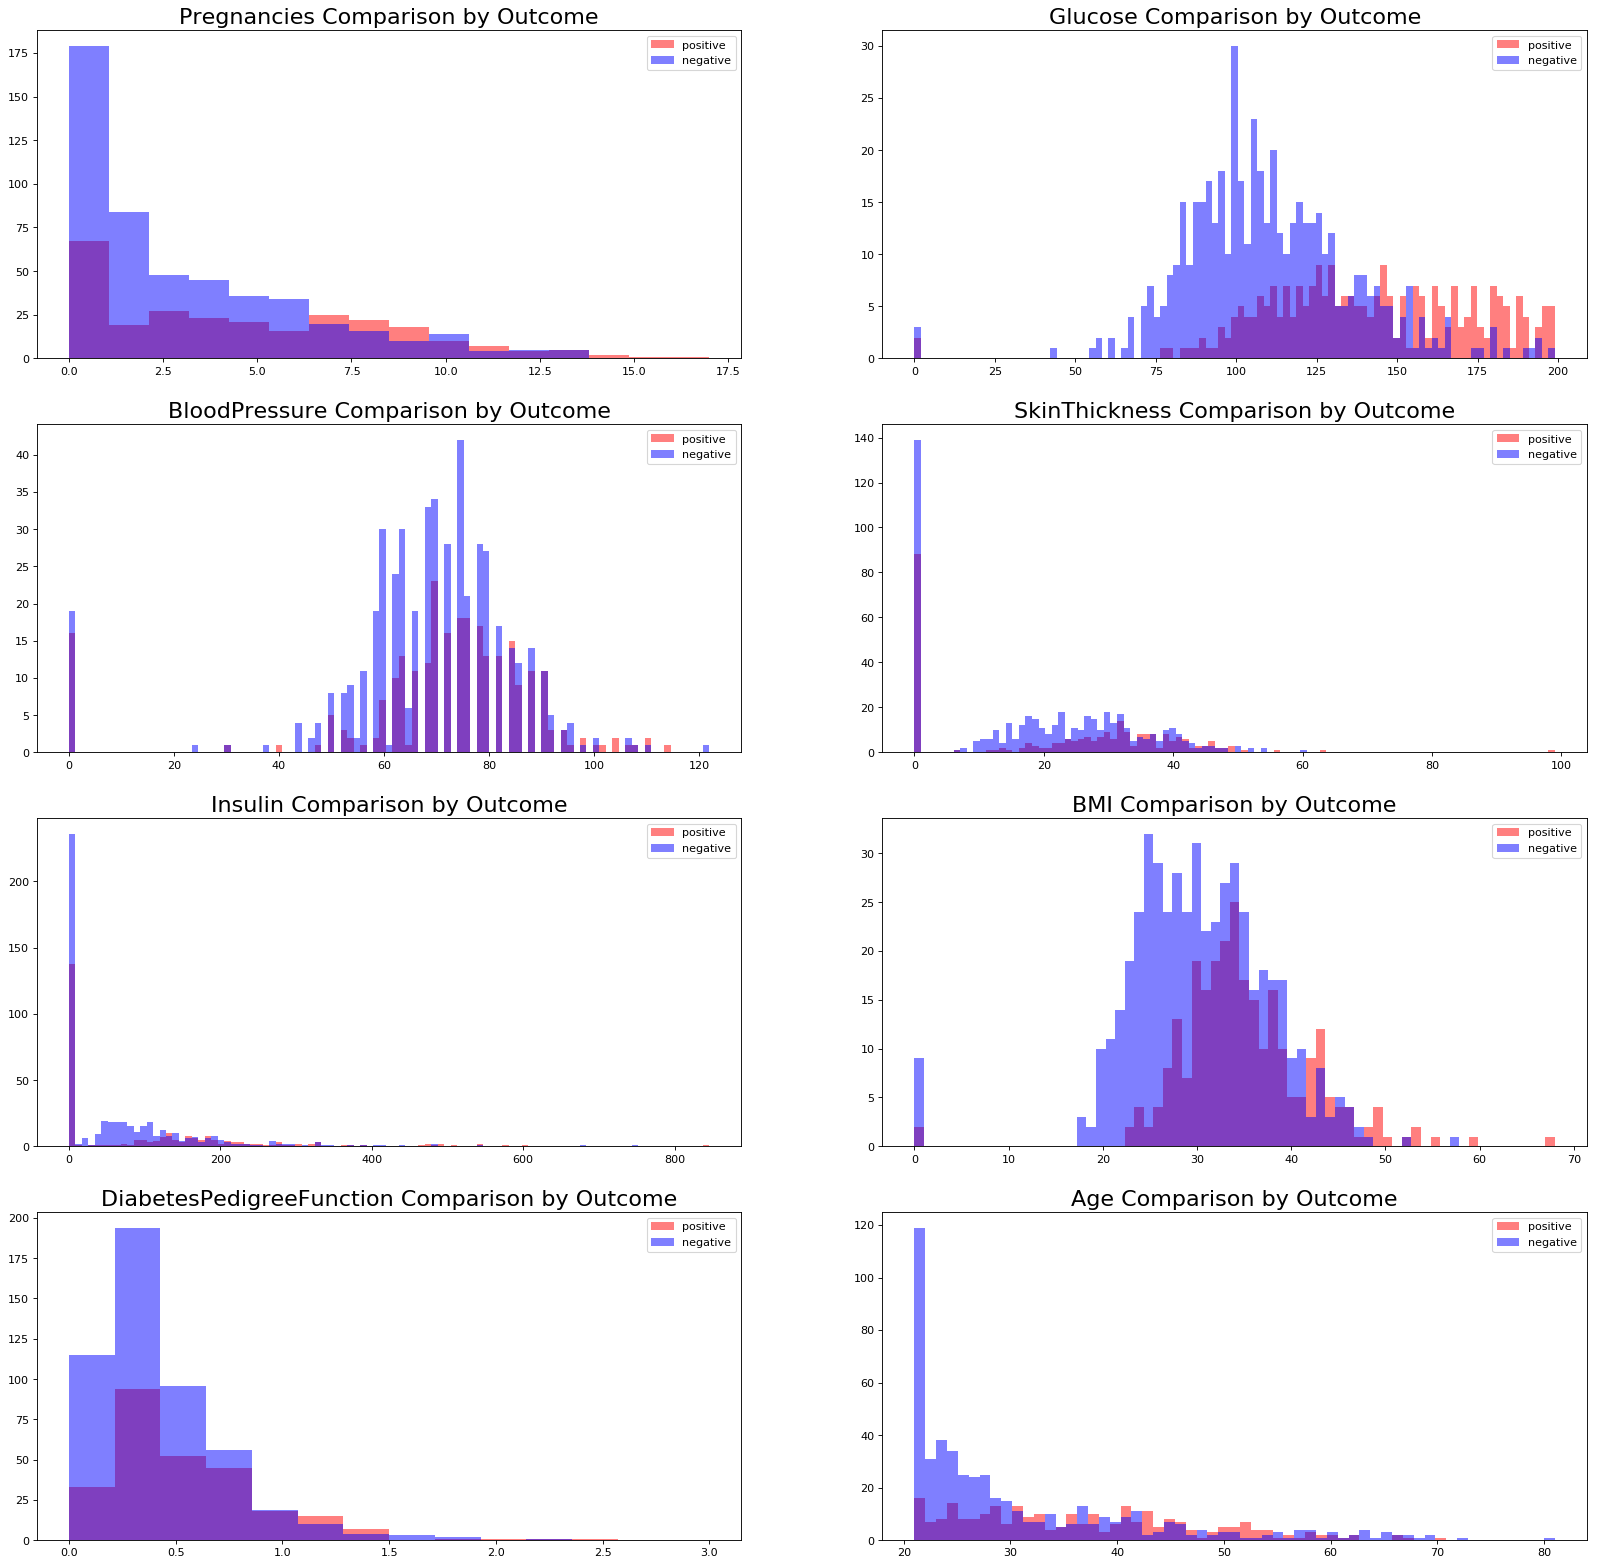

In [12]:
# Separate Dataset by Outcome
diabetes_pos = diabetes[diabetes['Outcome'] == 1]
diabetes_neg = diabetes[diabetes['Outcome'] == 0]

diabetes_col = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
i = 0
fig, axs = plt.subplots(4, 2)
for ele in diabetes_col:
    # 从患病/没患病的数据库中取出同样的数据
    x = diabetes_pos[ele].values
    y = diabetes_neg[ele].values
    # 计算当前数据的最小值和最大值，确定画图的边界
    min_val = np.floor(diabetes[ele].min())
    max_val = np.ceil(diabetes[ele].max())
    bins_val = max_val - min_val
    if bins_val > 100:
        bins_val = 100
    elif bins_val < 15:
        bins_val = 15
    bins = np.linspace(min_val, max_val, bins_val)
    # 画图
    fig.set_figheight(25)
    fig.set_figwidth(25)
    fig.set_dpi(80)
    axs[i//2, i%2].hist(x, bins, alpha=0.5, label='positive', color='red')
    axs[i//2, i%2].hist(y, bins, alpha=0.5, label='negative', color='blue')
    axs[i//2, i%2].set_title(ele + ' Comparison by Outcome', fontsize=20)
    axs[i//2, i%2].legend(loc='upper right')
    i += 1

以上，我们用颜色区分患者（红色）和非患者（蓝色）的predictor的分布图（Histogram）。对于每一个predictor，我们都可以看到一些明确的区别，这是一个很好的现象，分类算法本质上就是通过学习各类predictor的区别，来进行分类预测。

但同时，我们也观察到了一些异常值：
* Glucose, BloodPressure, SkinThickness, Insulin, BMI 都有值为0的observation，这是不可能的。
* SkinThickness和Insulin有大量为0的值（>100）。

**(3) 异常值处理**

我们此处假设“数据为0”这种现象是随机的，我们采用下面两个处理方式：
* 对于异常值较少的predictor，包括Glucose, BloodPressure, BMI，我们删除包含异常值的observation。
* 对于异常值较多的predictor，SkinThickness和Insulin，我们建立两份数据，并且分别建模比较结果：

    1) 数据集1: 删除这两个predictor，这样数据集中有比较多的observation
    
    2) 数据集2: 删除包含异常值的observation，这样数据集中的observation具备所有的predictor

以下是生成数据集1的代码：

In [13]:
# 将BMI, Glucose, BloodPressure大于0的值筛选出来
diabetes_clean = diabetes[(diabetes['BMI'] > 0) & (diabetes['Glucose'] > 0) & (diabetes['BloodPressure'] > 0)]
# 删除SkinThickness和Insulin两个predictor
diabetes_clean = diabetes_clean.drop(columns=['SkinThickness', 'Insulin'])
# 重新建立索引
diabetes_clean = diabetes_clean.reset_index(drop=True)
# 查看生成的数据集的数据量
diabetes_clean.shape

(724, 7)

经过以上处理，数据集1(diabetes_clean)中包含724个observation，6个predictor，1个outcome。

以下是生产数据集2的代码：

In [14]:
# 将SkinThickness, BMI, Insulin, Glucose, BloodPressure大于0的值筛选出来
diabetes_nonzero = diabetes[(diabetes['SkinThickness'] > 0) & (diabetes['BMI'] > 0) & (diabetes['Insulin'] > 0) & (diabetes['Glucose'] > 0) & (diabetes['BloodPressure'] > 0)]
# 重新建立索引
diabetes_nonzero = diabetes_nonzero.reset_index(drop=True)
# 查看生成的数据集的数据量
diabetes_nonzero.shape

(392, 9)

经过以上处理，数据集2(diabetes_nonzero)中包含392个observation，8个predictor，1个outcome。

综上，由于数据的两个局限性：**1) 数据量较小 2) 包含异常值**，我们生成了两个数据集：

* 数据集1的优点是保留了尽可能多的observation，缺点是舍弃了两个predictor。
* 数据集2的优点是包含愿数据中所有的predictor，缺点是舍弃了约一半的observation。

此刻，我们并不知道哪一个数据集对于建模的精度更有帮助，所以我们会分别对两个数据集建立逻辑回归模型，然后比较模型的结果，从而得出更好的模型。

**(4) 数据关联性**

当两个predictor具有高的相关性的时候，模型会产生动荡。当面对这样的情况时，我们可能会从中选取更有代表性predictor来进行回归分析（Regression Analysis）。我们可以通过pandas的`corr()`方法来计算任意两个feature之间的相关性（correlation）。我通常观察的是correlation大于0.85的情况，如果发生就有可能让模型不稳定。关于predictors高相关性对模型带来的影响，感兴趣的同学可以参考这个教程：[Highly Correlated Predictors](https://newonlinecourses.science.psu.edu/stat501/node/346/)

In [15]:
diabetes.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


可以观察到，对角线的数值都是1，其他数值关于对角线对称。只观察两个不同predictor之间的correlation，所以我们可以看对角线以下的部分，并且忽略**outcome**那一行。

由于没有值在0.85以上，所以我们的模型应该不会有predictor之间高相关性带来的问题。

## 建立模型

接下来，我们进入建模环节。首先我们对数据集1进行预处理，思路如下：
* 抽取25%的数据用于测试，75%的数据用于训练模型
* 将predictor和outcome分开，赋值变量X和Y

**(1) 引入第三方库：**

In [16]:
# 'train_test_split'用于抽取训练数据和测试数据
from sklearn.model_selection import train_test_split
# 'LogisticRegression'用于建立逻辑回归模型
from sklearn.linear_model import LogisticRegression

**(2) 分拆训练/测试数据**

In [17]:
# train_test_split()函数用于抽取训练数据和测试数据。
# 'test_size=0.25'意思是25%的数据作为训练数据。
# 'stratify=diabetes_clean['Outcome']'是指的在两类人群中分别取25%作为测试数据。这样的目的是确保测试数据和训练数据中，患糖尿病人数/无患糖尿病人数比例相当。
train,test=train_test_split(diabetes_clean,test_size=0.25,stratify=diabetes_clean['Outcome'])

# 用于训练的train_X和用于测试的test_X只包含predictor，所以删除outcome
train_X=train.drop(columns=['Outcome'])
test_X=test.drop(columns=['Outcome'])

# 生成用于训练的train_Y和用于测试的test_Y
train_Y=train['Outcome']
test_Y=test['Outcome']

将数据打印出来确认：

In [114]:
train_X.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
513,2,91,62,27.3,0.525,22
645,2,157,74,39.4,0.134,30
305,2,120,76,39.7,0.215,29
373,2,105,58,34.9,0.225,25
179,5,130,82,39.1,0.956,37


In [115]:
train_Y.head()

513    0
645    0
305    0
373    0
179    1
Name: Outcome, dtype: int64

接下来我们开始建立模型：

**(3) 建模**

模型的建立和训练非常简单，只需要下面这两行：

In [21]:
# 建立一个LogisticRegression类的实例，命名为model1
model1 = LogisticRegression()
# 将训练数据train_X,train_Y灌入模型的fit()函数，完成训练
model1.fit(train_X,train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

我们可以看到，以上出现了一个复杂的输出。LogisticRegression()括号中的内容就是用于进行逻辑回归训练的默认参数。这些参数不在我们教程的范畴里，我们现在只需要使用默认的参数就好。对这些参数含义感兴趣的同学可以参考官方文档：[sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

**(4) 评估结果**

我们可以使用metrics的accuracy_score()方法来评估预测结果的准确度。这个方法干的事情很简单，就是看预测结果有多少比例是正确的。所以accuracy_score()的返回值在0到1之间，越高说明模型的预测越准确。

In [29]:
# 引入metrics用于评估模型的预测结果
from sklearn import metrics
# 调用模型的predict()方法，对预测数据test_X进行预测
prediction1=model1.predict(test_X)
# 使用metrics的accuracy_score()方法评估预测结果的准确度
print('The accuracy of the Logistic Regression Model1 is',metrics.accuracy_score(prediction,test_Y))

The accuracy of the Logistic Regression Model1 is 0.7348066298342542


以上结果，意思是模型预测对了大约73.48%的结果。如果你得到的数值和此处不一样，这很正常。你可以思考一下造成这个偏差的原因，我们会在下一节讲解。

接下来，我们对数据集2进行训练，评估model2的准确度，来和model1比较结果。

**(5) 训练第二个模型**

In [37]:
# 拆分数据集2
train_2,test_2=train_test_split(diabetes_nonzero,test_size=0.25,stratify=diabetes_nonzero['Outcome'])

# 用于训练的train_2_X和用于测试的test_2_X只包含predictor，所以删除outcome
train_2_X=train_2.drop(columns=['Outcome'])
test_2_X=test_2.drop(columns=['Outcome'])

# 生成用于训练的train_2_Y和用于测试的test_2_Y
train_2_Y=train_2['Outcome']
test_2_Y=test_2['Outcome']

# 建立一个LogisticRegression类的实例，命名为model2
model2 = LogisticRegression()
# 将训练数据train_2_X,train_2_Y灌入模型的fit()函数，完成训练
model2.fit(train_2_X,train_2_Y)

# 调用模型的predict()方法，对预测数据test_2_X进行预测
prediction2=model2.predict(test_2_X)
# 使用metrics的accuracy_score()方法评估预测结果的准确度
print('The accuracy of the Logistic Regression Model2 is',metrics.accuracy_score(prediction2,test_2_Y))

The accuracy of the Logistic Regression Model2 is 0.7346938775510204


这样我们就得到了新的模型，并且得到了一个和model1非常相似的准确度。

但是，当你执行这段代码的时候，可能会得到不同的准确度，而且结果之间可能偏差较大。我执行了5次，预测结果从0.71到0.81不等。造成波动的原因是，因为拆分数据集有随机性，并且我们的数据量比较小，所以拆分数据的随机性会对结果产生影响。

由于结果的不稳定，我们很难通过以上的准确度来比较两个模型的优劣。那么，有没有更好的办法能够稳定的评估模型结果呢？

有的，那就是**交叉验证（Cross Validation）**。概念是将同一份数据数据拆分成多组，训练出多个模型，对模型评估。多组的准确度去平均，从而得到更稳定、更能代表模型能力的准确度。具体如何操作我们会在下一章进行介绍。

## Summary & Next

通过本章的实战，我们建立了一个用于预测糖尿病的分类算法，其预测准确度约为73%。

在这一章中，我们学习了：

* **将数据可视化，观察数据分布：**我们绘制了数据分布图，比较了糖尿病患者/非患者的predictor分布情况，对分析的可行性有了大概的预判。

* **2种处理异常数据的方式：**1）删除异常值 2）去除异常值较多的predictor。这两个方法只是冰山一角，而且并不一定是最好的处理方式。处理异常值是Data Science中很重要的一个工作，这方面我的老师Jerome P Reiter有一篇很棒的论文，推荐给大家：[Multiple Imputation for Statistical Disclosure Limitation](https://www.scb.se/contentassets/ca21efb41fee47d293bbee5bf7be7fb3/multiple-imputation-for-statistical-disclosure-limitation.pdf)

* **如何建立逻辑回归模型(Logistic Regression Model)**

* **如何评估逻辑回归模型的结果：**本章中我们通过分类的准确度来评估了模型的表现，也呈现了这个标准的一些局限性。下一章我们会进一步介绍如何评估分类算法的表现。

大家可能发现，在目前的教程中建模的过程是很快的，而且都是使用sklearn中的方法，在建模这一步我们要做的事情不多。而更复杂的工作往往在于数据的预处理，数据探索和可视化分析。在医疗数据中尤其是这样，因为医疗数据纷繁复杂，有大量的前期工作，这也是医疗项目最大的难点之一，但同时也是非常有价值的工作。

下一章我们会介绍更好的的评估分类算法的方法，再之后我们还会学习一个新的分类算法K-Nearest Neighbour。

In [34]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction,test_Y))

NameError: name 'DecisionTreeClassifier' is not defined

In [118]:
types=['rbf','linear']
for i in types:
    model=svm.SVC(kernel=i)
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    print('Accuracy for SVM kernel=',i,'is',metrics.accuracy_score(prediction,test_Y))

Accuracy for SVM kernel= rbf is 0.6519337016574586
Accuracy for SVM kernel= linear is 0.7790055248618785


In [193]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

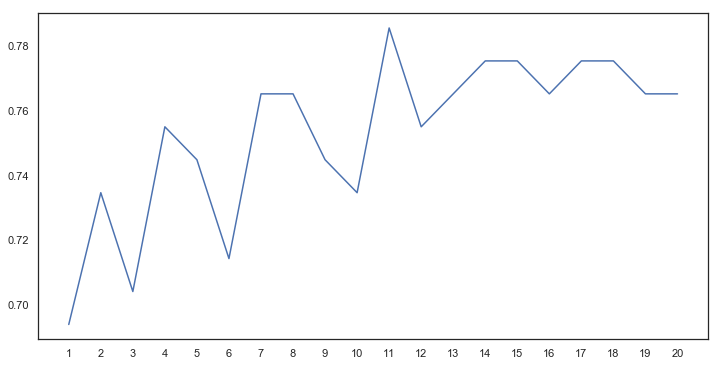

Accuracies for different values of n are: [0.69387755 0.73469388 0.70408163 0.75510204 0.74489796 0.71428571
 0.76530612 0.76530612 0.74489796 0.73469388 0.78571429 0.75510204
 0.76530612 0.7755102  0.7755102  0.76530612 0.7755102  0.7755102
 0.76530612 0.76530612]


In [231]:
a_index=list(range(1,21))
a=pd.Series()
x=list(range(1,21))
for i in list(range(1,21)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.figure(figsize=(12, 6))
plt.plot(a_index, a)
plt.xticks(x)
plt.show()
print('Accuracies for different values of n are:',a.values)

In [131]:
# Using clean dataset
train,test=train_test_split(diabetes_clean,test_size=0.25,random_state=0,stratify=diabetes_clean['Outcome'])# stratify the outcome
train_X=train.drop(columns=['Outcome'])
test_X=test.drop(columns=['Outcome'])
train_Y=train['Outcome']
test_Y=test['Outcome']

model_eval=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=5),DecisionTreeClassifier()]
for i in models:
    model = i
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    model_eval.append(metrics.accuracy_score(prediction,test_Y))
models_dataframe=pd.DataFrame(model_eval,index=classifiers)   
models_dataframe.columns=['Accuracy']
models_dataframe

,Accuracy
Linear Svm,0.779006
Radial Svm,0.651934
Logistic Regression,0.762431
KNN,0.779006
Decision Tree,0.751381


In [167]:
# Using non-zero dataset
train,test=train_test_split(diabetes_nonzero,test_size=0.25,random_state=0,stratify=diabetes_nonzero['Outcome'])# stratify the outcome
train_X=train.drop(columns=['Outcome'])
test_X=test.drop(columns=['Outcome'])
train_Y=train['Outcome']
test_Y=test['Outcome']

model_eval=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=5),DecisionTreeClassifier()]
for i in models:
    model = i
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    model_eval.append(metrics.accuracy_score(prediction,test_Y))
models_dataframe=pd.DataFrame(model_eval,index=classifiers)   
models_dataframe.columns=['Accuracy']
models_dataframe

,Accuracy
Linear Svm,0.765306
Radial Svm,0.673469
Logistic Regression,0.765306
KNN,0.744898
Decision Tree,0.744898


In [137]:
from sklearn.ensemble import RandomForestClassifier 
model= RandomForestClassifier(n_estimators=100,random_state=0)
X=diabetes_nonzero.drop(columns=['Outcome'])
Y=diabetes_nonzero['Outcome']
model.fit(X,Y)
pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

Glucose                     0.229134
Insulin                     0.147226
Age                         0.144594
BMI                         0.118622
DiabetesPedigreeFunction    0.112304
SkinThickness               0.086360
Pregnancies                 0.084841
BloodPressure               0.076918
dtype: float64

In [138]:
from sklearn.ensemble import RandomForestClassifier 
model= RandomForestClassifier(n_estimators=100,random_state=0)
X=diabetes_clean.drop(columns=['Outcome'])
Y=diabetes_clean['Outcome']
model.fit(X,Y)
pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

Glucose                     0.308529
BMI                         0.185445
Age                         0.158302
DiabetesPedigreeFunction    0.157552
BloodPressure               0.097454
Pregnancies                 0.092718
dtype: float64

## Normalize and Fit Model Using Important Features

In [190]:
diab2=diabetes_clean[['Glucose','BMI','Age','DiabetesPedigreeFunction','Outcome']]
from sklearn.preprocessing import StandardScaler #Standardisation
features=diab2.drop(columns=['Outcome'])
features_standard=StandardScaler().fit_transform(features)# Gaussian Standardisation
x=pd.DataFrame(features_standard,columns=[['Glucose','BMI','Age','DiabetesPedigreeFunction']])
x['Outcome']=diab2['Outcome']
outcome=x['Outcome']



# from sklearn import preprocessing
# data = diabetes_clean[['Glucose','BMI','Age','DiabetesPedigreeFunction','Outcome']]
# feature = diabetes_clean[['Glucose','BMI','Age','DiabetesPedigreeFunction']]
# min_max_scaler = preprocessing.MinMaxScaler()
# feature_scaled = min_max_scaler.fit_transform(feature)
# feature_normalized = pd.DataFrame(feature_scaled,columns=['Glucose','BMI','Age','DiabetesPedigreeFunction'])
# x = pd.concat([feature_normalized, diabetes_clean['Outcome']], axis=1)
# x


train1,test1=train_test_split(x,test_size=0.25,random_state=0,stratify=x['Outcome'])
train_X1=train1[train1.columns[:4]]
test_X1=test1[test1.columns[:4]]
train_Y1=train1['Outcome']
test_Y1=test1['Outcome']

abc=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier()]
for i in models:
    model = i
    model.fit(train_X1,train_Y1)
    prediction=model.predict(test_X1)
    abc.append(metrics.accuracy_score(prediction,test_Y1))
new_models_dataframe=pd.DataFrame(abc,index=classifiers)   
new_models_dataframe.columns=['New Accuracy']    

In [191]:
new_models_dataframe=new_models_dataframe.merge(models_dataframe,left_index=True,right_index=True,how='left')
new_models_dataframe['Increase']=new_models_dataframe['New Accuracy']-new_models_dataframe['Accuracy']
new_models_dataframe

,New Accuracy,Accuracy,Increase
Linear Svm,0.790055,0.765306,0.024749
Radial Svm,0.790055,0.673469,0.116586
Logistic Regression,0.790055,0.765306,0.024749
KNN,0.751381,0.744898,0.006483
Decision Tree,0.712707,0.744898,-0.032191


## Cross Validation

In [192]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation

In [194]:
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts

In [195]:
xyz=[]
accuracy=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier()]
for i in models:
    model = i
    cv_result = cross_val_score(model,x[x.columns[:4]],x['Outcome'], cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame(abc,index=classifiers)   
new_models_dataframe2.columns=['CV Mean']    
new_models_dataframe2

,CV Mean
Linear Svm,0.790055
Radial Svm,0.790055
Logistic Regression,0.790055
KNN,0.751381
Decision Tree,0.712707


In [198]:
accuracy

[array([0.75342466, 0.83561644, 0.75342466, 0.69863014, 0.76388889,
        0.77777778, 0.79166667, 0.86111111, 0.73611111, 0.79166667]),
 array([0.73972603, 0.84931507, 0.73972603, 0.65753425, 0.79166667,
        0.80555556, 0.80555556, 0.86111111, 0.72222222, 0.84722222]),
 array([0.73972603, 0.83561644, 0.73972603, 0.69863014, 0.76388889,
        0.79166667, 0.80555556, 0.875     , 0.70833333, 0.80555556]),
 array([0.67123288, 0.78082192, 0.69863014, 0.60273973, 0.70833333,
        0.76388889, 0.70833333, 0.875     , 0.70833333, 0.81944444]),
 array([0.68493151, 0.71232877, 0.63013699, 0.67123288, 0.69444444,
        0.65277778, 0.72222222, 0.75      , 0.73611111, 0.72222222])]

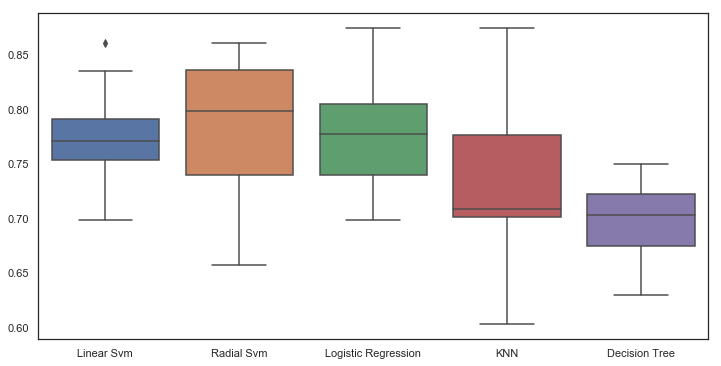

In [230]:
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
# boxplot = df.boxplot(column=['Col1', 'Col2', 'Col3'])

box=pd.DataFrame(accuracy,index=classifiers)
box = box.T
plt.figure(figsize=(12, 6))
sns.boxplot(data=box)
pyplot.show()

In [94]:
# sns.pairplot(data=diabetes, hue='Outcome', diag_kind='kde', plot_kws = {'alpha': 0.6})
# plt.show()

In [83]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = pyplot.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = pyplot.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = pyplot.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


# def corrplot(data, size_scale=500, marker='s'):
#     corr = pd.melt(data.reset_index(), id_vars='index')
#     corr.columns = ['x', 'y', 'value']
#     heatmap(
#         corr['x'], corr['y'],
#         color=corr['value'], color_range=[-1, 1],
#         palette=sns.diverging_palette(20, 220, n=256),
#         size=corr['value'].abs(), size_range=[0,1],
#         marker=marker,
#         x_order=data.columns,
#         y_order=data.columns[::-1],
#         size_scale=size_scale
#     )

In [62]:
# diabetes.columns.values
diabetes_col = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [56]:
# Separate Dataset by Outcome
diabetes_pos = diabetes[diabetes['Outcome'] == 1]
diabetes_neg = diabetes[diabetes['Outcome'] == 0]

In [58]:
# Function for calculating overlap between two histograms
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.sum(minima) / np.sum(hist_2)
    return intersection
    
for ele in diabetes_col:
    hist_1, _ = np.histogram(diabetes_pos[ele].values, bins=100, range=[-15, 15])
    hist_2, _ = np.histogram(diabetes_neg[ele].values, bins=100, range=[-15, 15])
    intersection = return_intersection(hist_1, hist_2)
    print(ele + ' intersection among two group is: ' + str(intersection))

Pregnancies intersection among two group is: 0.484
Glucose intersection among two group is: 0.6666666666666666
BloodPressure intersection among two group is: 0.8421052631578947
SkinThickness intersection among two group is: 0.5053763440860215
Insulin intersection among two group is: 0.5822784810126582
BMI intersection among two group is: 0.2222222222222222
DiabetesPedigreeFunction intersection among two group is: 0.514
Age intersection among two group is: nan
Outcome intersection among two group is: 0.0


/Users/sicongzhao/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


[Text(0.5, 0, 'Pregnancies'),
 Text(1.5, 0, 'Glucose'),
 Text(2.5, 0, 'BloodPressure'),
 Text(3.5, 0, 'SkinThickness'),
 Text(4.5, 0, 'Insulin'),
 Text(5.5, 0, 'BMI'),
 Text(6.5, 0, 'DiabetesPedigreeFunction'),
 Text(7.5, 0, 'Age'),
 Text(8.5, 0, 'Outcome')]

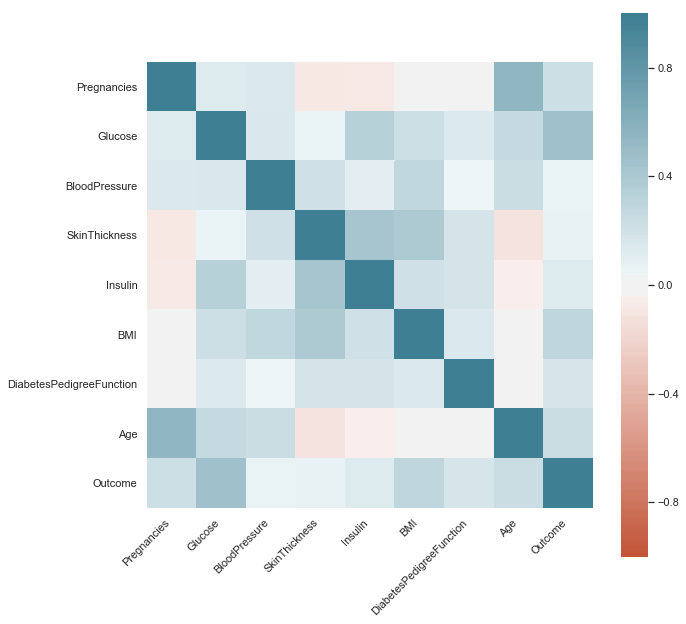

In [282]:
corr = diabetes.corr()
plt.figure(figsize=(10, 10))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# plt.figure(figsize=(10, 10))
# corrplot(corr)